importing

In [ ]:
import os
import sys
import cv2 as cv
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pdb
from tqdm import tqdm
import fnmatch
import random
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
import time
import copy
import pickle
import shutil



mounting drive

In [ ]:


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%load_ext autoreload
%autoreload 2
sys.path.append('/content/drive/My Drive/DL project/final')
from Dataset_Functions import read_list

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


read scores dataset and standartize scores

In [ ]:

Dataset = read_list('/content/drive/My Drive/DL project/final/Dataset')

# standartizing score
scores = np.array([a[1] for a in Dataset])
mean = np.mean(scores)
std = np.std(scores-mean)
Dataset = [[a[0], (a[1]-mean)/std] for a in Dataset] 


shaffeling dataset and creating a dataloader

In [ ]:
random.seed(513) # shuffle dataset the same way every time
length = len(Dataset)
shuffle_Dataset = Dataset.copy()
random.shuffle(shuffle_Dataset)

# parameters for datalouder
train_per = 0.7
val_per = 0.15
test_per = 0.15
batch_size = 32

# train val test split
train_dataset = shuffle_Dataset[:round(length*train_per)]
val_dataset = shuffle_Dataset[round(length*train_per):round(length*(train_per+val_per))]
test_dataset = shuffle_Dataset[round(length*(train_per+val_per)):]

#creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)

train_val_dataloader = {"train": train_dataloader, "val": val_dataloader}

creating model to train

In [ ]:
NEW_MODEL = True # dont use saved model

#to use resnet as a basis
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1) # make 1 output - regretion problem
model.conv1 = nn.Conv2d(45, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # if use 15 input pictures
#model.conv1 = nn.Conv2d(45, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # if use 5 input pictures

#to use vgg as a basis
#model = torchvision.models.vgg16(pretrained=True)
#num_ftrs = model.classifier[6].in_features
#model.classifier[6] = nn.Linear(num_ftrs, 1)
#model.features[0] = nn.Conv2d(15, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# use gpu if possible
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
print('using device:', device)

# creating optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-3, betas=(0.9, 0.9), eps=1e-016, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)






/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

using device: cpu


define training function

In [ ]:
def train_model(model, dataloaders, criterion, optimizer,scheduler, num_epochs=25, val_loss_history = [],train_loss_history = [], print_every=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e32
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            index = 0
            for inputs, labels in dataloaders[phase]:
                # reorder training data ransomly to prevent overfit. keep rgb channels together
                reorder = torch.randperm(15) * 3
                inputs = inputs[:,torch.stack((reorder, reorder + 1, reorder + 2),1).resize(45)]

                # option - use 5 pictures from 15
                #samples = torch.tensor(random.sample(range(15), 5)) * 3
                #inputs = inputs[:,torch.stack((samples, samples + 1, samples + 2),1).resize(15)]
                #inputs = inputs[:,0:15]

                # option - add noise to training data
                #if phase == 'train':
                  #input = inputs + 5 * torch.randn(inputs.size())
                index += 1
                inputs = inputs.to(device).to(torch.float32)
                labels = labels.to(device).to(torch.float32)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    #pdb.set_trace()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        if index % print_every == 0:
                          print(f'epoch: {epoch}, iteration: {index}, loss: {loss.item()}') 

                # statistics
                running_loss += loss.item() * inputs.size(0)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
              train_loss_history.append(epoch_loss)
            print('epoch {} {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                path = "/content/drive/My Drive/DL project/best_model.pt" 
                torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss_history':val_loss_history,
                'train_loss_history':train_loss_history}, path)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                path = "/content/drive/My Drive/DL project/last_model.pt" 
                torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss_history':val_loss_history,
                'train_loss_history':train_loss_history}, path)

        scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    plt.figure(1)
    plt.plot(val_loss_history)
    plt.figure(2)
    plt.plot(train_loss_history)
    return model, val_loss_history

train the model

Epoch 0/49
----------


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


epoch 0 train Loss: 0.9036
epoch 0 val Loss: 4.2742
Epoch 1/49
----------
epoch 1 train Loss: 0.8394
epoch 1 val Loss: 2.3057
Epoch 2/49
----------
epoch 2 train Loss: 1.0610
epoch 2 val Loss: 4.4962
Epoch 3/49
----------
epoch 3 train Loss: 2.1313
epoch 3 val Loss: 4.0295
Epoch 4/49
----------
epoch 4 train Loss: 1.7012
epoch 4 val Loss: 3.2385
Epoch 5/49
----------
epoch 5 train Loss: 2.1825
epoch 5 val Loss: 2.2846
Epoch 6/49
----------
epoch 6 train Loss: 2.4303
epoch 6 val Loss: 2.7236
Epoch 7/49
----------
epoch 7 train Loss: 0.6646
epoch 7 val Loss: 6.9365
Epoch 8/49
----------
epoch 8 train Loss: 1.7784
epoch 8 val Loss: 45.7115
Epoch 9/49
----------
epoch 9 train Loss: 2.1876
epoch 9 val Loss: 62.1948
Epoch 10/49
----------
epoch 10 train Loss: 1.1487
epoch 10 val Loss: 37.4324
Epoch 11/49
----------
epoch 11 train Loss: 0.7456
epoch 11 val Loss: 33.0990
Epoch 12/49
----------
epoch 12 train Loss: 0.8648
epoch 12 val Loss: 19.1066
Epoch 13/49
----------
epoch 13 train Loss: 0.

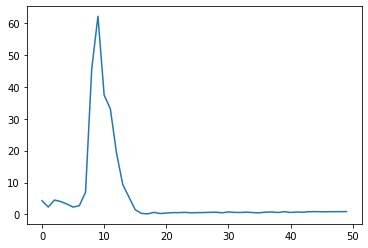

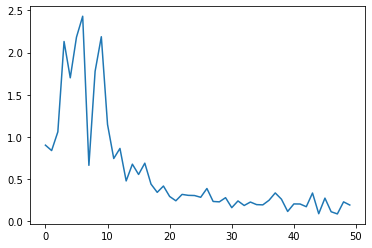

In [ ]:
if not(NEW_MODEL):
    path =  F"/content/drive/My Drive/DL project/last_model.pt" #use last model from previas train
    #path =  F"/content/drive/My Drive/DL project/last_model.pt" #use best model from previas train
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']) # use optimizer from previes trin
    val_loss_history = checkpoint["val_loss_history"]
    train_loss_history = checkpoint["train_loss_history"]
else:
  val_loss_history = []
  train_loss_history = []

loss = nn.L1Loss()
train_model(model, train_val_dataloader, loss, optimizer, scheduler, num_epochs=50, val_loss_history=val_loss_history,train_loss_history=train_loss_history, print_every=200)
print('')

plot learning graphs

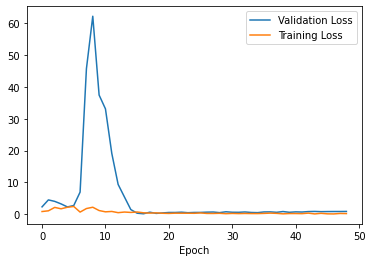

In [ ]:
path =  F"/content/drive/My Drive/DL project/last_model.pt" 
checkpoint = torch.load(path)
val_loss_history = checkpoint["val_loss_history"]
train_loss_history = checkpoint["train_loss_history"]
plt.figure(1)
plt.plot(val_loss_history[1:], label="Validation Loss")
plt.plot(train_loss_history[1:], label="Training Loss")
plt.xlabel("Epoch")
plt.legend()


checking test loss of best model

In [ ]:
path =  F"/content/drive/My Drive/DL project/best_model.pt" 
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
val_loss_history = checkpoint["val_loss_history"]
model.eval()
criterion = nn.L1Loss()
running_loss = 0
for inputs, labels in test_dataloader:
    inputs = inputs.to(device).to(torch.float32)
    labels = labels.to(device).to(torch.float32)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)
total_loss = running_loss / len(test_dataloader.dataset)
print(f'test loss on best model is: {total_loss}')

test loss on best model is: 1.8418992757797241
